In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Assumptions
1. No capital investments after the initiation of the pool
2. All interest is reinvested in the pool at the same interest rate
3. 1-loan_demand_rate of the total pool at the start of each month including the reserves is loaned out: req double check if there is a legislative minimum for this
4. Probability of default is uniformly distributed (Assuming all debtors are operate independantly of each other and are identically distributed with each debtor following a bernoulli distribution at the same default rate, implying the  overall default of pool is distributed as a binomial distribution. With reference to CLT, this converges towards a normal distribution if n>50?100 )
5. Assume loans over time are uncorrellated and the default probability is constant throughout the year.
6. Investors are paid at the end of the year, no withdrawals in between.
7. Net income is defined as the spread between interest paid to investors and interest recieved from loan recipients
8. Revenue is defined as total interest recieved from loan recepients.
9. Net Income is spread between interest from loans, other charges and that paid to investors


In [138]:

def simulate_loan_revenue(capital_investment, loan_size, monthly_loan_interest_rate,
                          annual_investor_interest_rate, default_rate, loan_demand_rate,
                          n_simulations=10000):
    """
    Simulates a loan portfolio to calculate the total revenue and profit, taking into account loan demand.
    Parameters:
    capital_investment (float): Total capital invested by investors.
    loan_size (float): Size of each individual loan.
    monthly_loan_interest_rate (float): Monthly interest rate for each loan (as a decimal).
    annual_investor_interest_rate (float): Annual interest rate paid to investors (as a decimal).
    default_rate (float): The expected default rate of the loans (as a decimal).
    loan_demand_rate (float): The percentage of the pool that is loaned out each month (as a decimal).
    n_simulations (int): The number of simulations to run.
    Returns:
    dict: A dictionary containing the average total revenue and total profit.
    """
    final_balances = []
    total_profits = []
    balances={}
    rev={}
    loss={}
    interest_rev={}
    for i in range(n_simulations):
        monthly_revenue = []
        year_bal=[]
        default_loss=[]
        int_rev=[]
        #Total lendable capital at start of the month after removing reserves
        current_float=capital_investment * loan_demand_rate 
        year_bal.append(capital_investment)
        for month in range(12):  # For each month in the year
            # Calculate the amount of capital loaned out based on demand
            loaned_out_capital = current_float
            # Determine the number of loans given out
            number_of_loans = int(loaned_out_capital // loan_size)
            # Simulate defaults
            defaults = np.random.rand(number_of_loans) < default_rate
            # Calculate the total amount collected from non-defaulted loans
            
            total_collected = np.sum(
                ~defaults) * loan_size * (1 + monthly_loan_interest_rate)
            # Add to monthly revenue
            balance=total_collected+(current_float*(1-loan_demand_rate)/loan_demand_rate)
            current_float= 0.8*(balance) #update capital balance
            
            monthly_revenue.append(total_collected-loaned_out_capital) #nb: think of this as revenue net bad debts as it includes defaults
            int_rev.append(total_collected-(np.sum(~defaults) * loan_size)) #revenue from interest per month
            default_loss.append(np.sum(defaults*loan_size)) #default loss per month
            year_bal.append(balance) #monthly balances for the year including initial

        
        rev[i]=monthly_revenue
        interest_rev[i]=int_rev
        loss[i]=default_loss
        balances[i]=year_bal
        
        # Total annual balance
        final_balance = year_bal[12]
        final_balances.append(final_balance)
        # Total amount to be paid to investors
        investor_payout = capital_investment * (1 + annual_investor_interest_rate)
        # Total profit
        profit = final_balance - investor_payout
        total_profits.append(profit)
    # Average over all simulations
    average_final_balance = np.mean(final_balances)
    average_total_profit = np.mean(total_profits)
    return {
            "average_total_capital_balance": average_final_balance, 
            "average_total_profit": average_total_profit, 
            "revenue":  rev,
            "interest_revenue": interest_rev,
            "balances": balances,
            "default_loss" : loss,
            "repayment": investor_payout
    }


Note: Appending to arrays are expensive, too speed this function up comment out int_rev, month_revenue and default_loss array operations in last 4 lines of the inner fo loop. Do not comment out year_bal

In [208]:
# Example usage
capital_investment = 1000000  # R1,000,000
loan_size = 200  # R200 per loan
monthly_loan_interest_rate = 0.05  # 5% per month
annual_investor_interest_rate = 0.10  # 10% annual interest rate for investors
default_rate = 0.10  # 10% default rate
loan_demand_rate = 0.8  # 80% of the pool is loaned out each month
results = simulate_loan_revenue(capital_investment, loan_size, monthly_loan_interest_rate,
                                annual_investor_interest_rate, default_rate, loan_demand_rate)
print("Average EOY Capital Balance: ", results["average_total_capital_balance"])
print("Investor Repayment: ", results["repayment"])
print("Average Total Profit: ", results["average_total_profit"])

Average EOY Capital Balance:  581926.6000220942
Investor Repayment:  1100000.0
Average Total Profit:  -518073.39997790585


## Some Plots for fun

In [182]:
#set up x axis values, note x1 has 0 and x does not.
x=np.array(range(1,13,1))
x1=np.array(range(0,13,1))

In [204]:
"""
Plotting function: 
x: expects the x axis as an array, eg: [1:12] because 12 months. 
path_dict: {0:[val1, val2, ... valn], 1:[val1, val2 ... valn]... ]}
offset: if you want to offset each monthly value by some value or an np array of values the same length as x axis values
cumulative: will calculate and plot cumulative paths if True. False by default. Instead of eg if a=[1,2,3] cum(a)=[1,3,6]
average: calculates and plots the average path if True, False by default
"""
def path_plot(x, path_dict, offset, title, x_title, y_title, cumulative=False, average=False):
    
    path_d={}
    plt.figure(figsize=(12,6))
    
    #if true, this makes a accumulates the amounts over time
    if cumulative:
        for i in path_dict.keys():
            path_d[i]=[]
            for j in range(len(path_dict[i])):
                path_d[i].append(sum(path_dict[i][0:j+1]))
    else:
        path_d=path_dict
    
    #averages the values per month
    if average:
        df=pd.DataFrame(path_d).transpose()
        path_d={}
        path_d[0]=np.array(df.mean(axis=0))
    
    #plotting each path
    for i in path_d.keys():
        plt.plot(x,np.array(path_d[i])-offset, alpha=0.5, linewidth=0.5)

    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(title)
    plt.show()

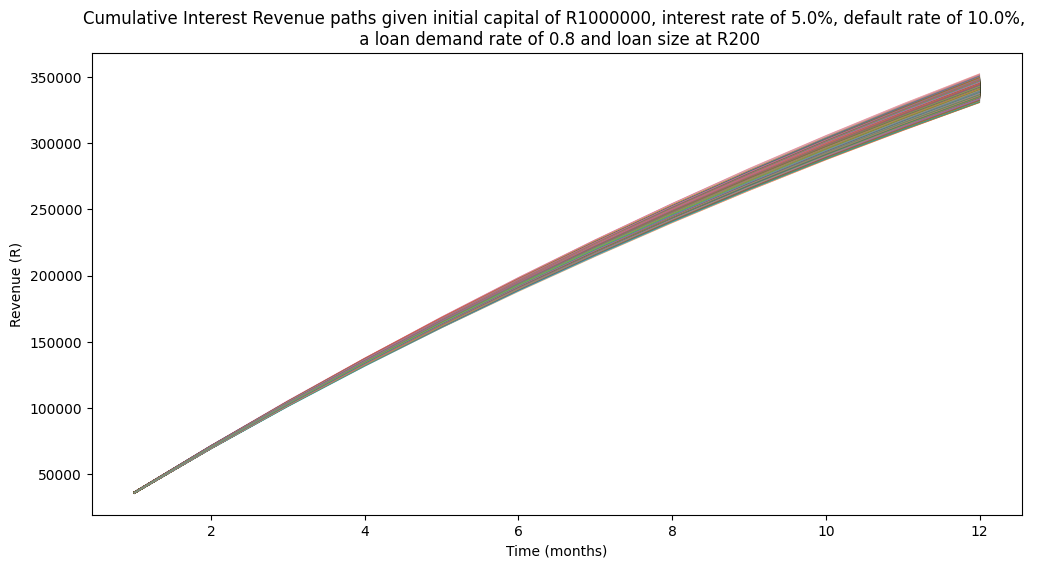

In [209]:
path_plot(x,
          results["interest_revenue"], 
          [0]*12, #this is an array of zeroes
          "Cumulative Interest Revenue paths given initial capital of R"+str(capital_investment)+ ", interest rate of "+str(monthly_loan_interest_rate*100)+ '%, default rate of '+str(default_rate*100)+"%, \n a loan demand rate of "+str(loan_demand_rate)+" and loan size at R"+str(loan_size), 
          "Time (months)",
          "Revenue (R)",
         True,
         False)

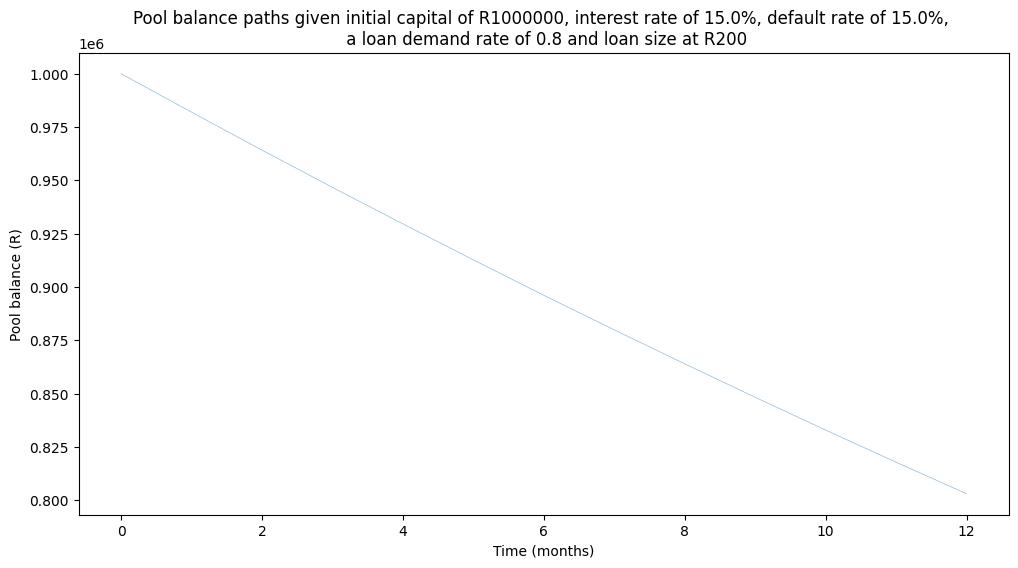

In [206]:
path_plot(x1,
          results["balances"],
          [0]*13,
          "Pool balance paths given initial capital of R"+str(capital_investment)+ ", interest rate of "+str(monthly_loan_interest_rate*100)+ '%, default rate of '+str(default_rate*100)+"%, \n a loan demand rate of "+str(loan_demand_rate)+" and loan size at R"+str(loan_size), 
          "Time (months)",
          "Pool balance (R)",
         False,
         True)

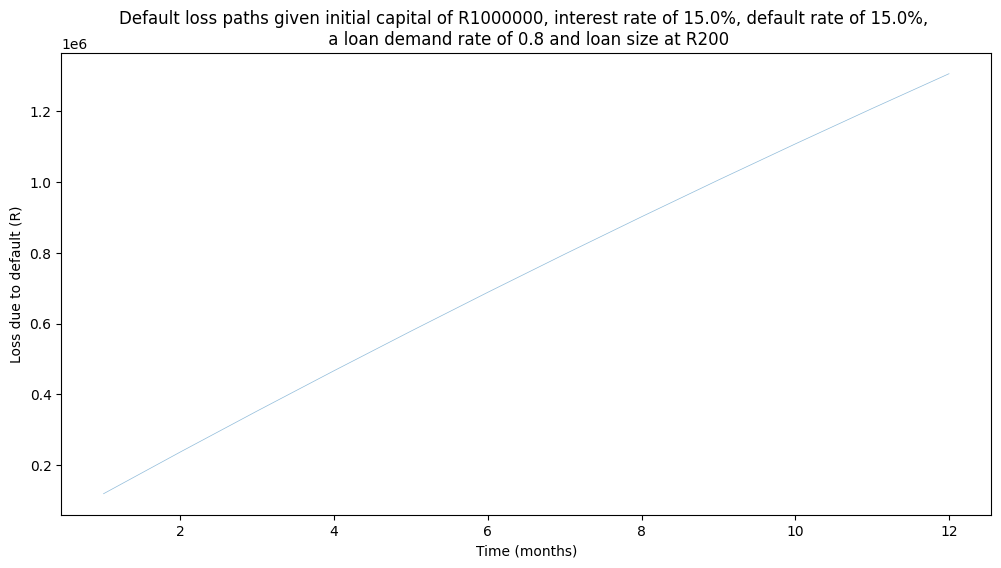

In [207]:
path_plot(x,
          results["default_loss"], 
          [0]*12,
          "Cumulative Default loss paths given initial capital of R"+str(capital_investment)+ ", interest rate of "+str(monthly_loan_interest_rate*100)+ '%, default rate of '+str(default_rate*100)+"%, \n a loan demand rate of "+str(loan_demand_rate)+" and loan size at R"+str(loan_size), 
          "Time (months)",
          "Loss due to default (R)",
         True,
         True)